# Analysis of Section 6.2

In [26]:
library(dplyr)
library(ggplot2)
library(ggpubr)
source("helper.r")
theme_set(theme_pubr(legend = "none"))

Warning message:
"package 'ggpubr' was built under R version 3.6.3"

### Data Preparation for Table 2

In [11]:
# path to folder, with folders for dataset results
path = "../data/runs/mlp/"
datasets = list.files(path)

# create list with one list containing one dataframe per dataset
data.list = lapply(datasets, function(data){
  
  data.path = paste0(path, data, "/2_3_effects_and_trees/")
  objectives = list.files(data.path)
  
  for(i in 1:length(objectives)){
 
    res = readRDS(paste0(data.path, objectives[i]))
    df.sub = res$result[[1]]$eval
    df.sub$objective = res$objective
    
    if(i == 1) df = df.sub
    else df = rbind(df, df.sub)
  }
  
  return(df)
})
names(data.list) = datasets


### Create Table 2 

In [12]:
df.conf       = create_table_features(data.list = data.list, objective = "SS_L2", target = "conf.rel", depth = 7)
df.conf.opt   = create_table_features(data.list = data.list, objective = "SS_L2", target = "conf.rel.opt.1", depth = 7)
df.neg_loglik = create_table_features(data.list = data.list, objective = "SS_L2", target = "neg_loglik.rel", depth = 7)
df.features   = cbind(df.conf, df.conf.opt[,2:3], df.neg_loglik[,2:3])
df.features[,2:7] = df.features[,2:7]*100
names(df.features) = c("hyperparameter", "MC.mean", "MC.sd", "OC.mean", "OC.sd", "NLL.mean", "NLL.sd")
print(df.features)


  hyperparameter  MC.mean    MC.sd  OC.mean    OC.sd NLL.mean   NLL.sd
1     batch_size 40.83266 14.88437 61.91107 13.52158 19.81016 19.53224
2  learning_rate 50.15802 13.73577 57.62318 14.35267 17.88621 20.51848
3    max_dropout 49.70382 15.41972 62.38183 11.86977 17.40855 18.19466
4      max_units 51.08953 15.16326 58.62245 12.73231 24.62329 21.97147
5       momentum 51.67007 14.50075 58.26209 12.74675 19.72032 21.66794
6     num_layers 30.61865 16.43168 50.90655 16.61280 13.83330 32.46066
7   weight_decay 36.26012 22.64671 61.03452 13.07309 11.94863 19.71143


### Create Figure 7

#### Extract dataset specific information

In [30]:
# Extract all data for dataset shuttle and iteration 1
dataset   = "shuttle"
iter      = 1
data.all  = readRDS(paste0(path, data, "/2_3_effects_and_trees/eval_SS_L2_20_1000.rds"))
testdata  = readRDS(paste0(path, dataset, "/2_1_testdata/testdata_1000.rds"))
features  = names(data.all$result[[1]]$reslist[[iter]])
optima    = readRDS(paste0(path, dataset,"/1_1_mlrmbo_runs/mlrmbo_run_lambda_1_30repls.rds" ))
traindata = optima$result[[iter]]$opt.path
optimum   = traindata[which.min(traindata$y), features]
gt        = readRDS(paste0(path, dataset, "/2_2_groundtruth_pdps/gtpdp_20_1000.rds"))

#### Prepare data for hyperparameter Max. Number of Units

In [40]:
# Calculate PDP and confidence estimates for hyperparameter max_units 
feat = "max_units"

# calculate global PDP and confidence bands
data = data.all$result[[1]]$reslist[[iter]][[feat]]
data.pdp = data$res.pdp
data.pdp$lower = data.pdp$mean - data.pdp$sd*1.96
data.pdp$upper = data.pdp$mean + data.pdp$sd*1.96

# Extract ICE curves
data.ice = data$res.ice

# Extract tree and split criteria for optimal subregions
tree = data$trees
split.criteria = find_split_criteria(tree[[1]], optimum)
split.criteria$values = round(split.criteria$values, 4)

# Extract true PDP and ICE estimates
gt.feat = gt[[1]][[feat]][[1]]
gt.pdp = gt.feat[gt.feat$.type=="pdp",]
gt.ice = gt.feat[gt.feat$.type == "ice",]

# Calculate PDP and confidence estimates for optimal subregion after last split
optimal.node = find_optimal_node(tree[[1]], optimum)
ind.opt = optimal.node$subset.idx
pdp.opt = data.ice[data.ice$.id %in% ind.opt,] %>% group_by(get(feat)) %>% summarise(mean.opt = mean(mean), sd.opt = mean(sd))
pdp.opt$lower = pdp.opt$mean.opt - pdp.opt$sd.opt*1.96
pdp.opt$upper = pdp.opt$mean.opt + pdp.opt$sd.opt*1.96
colnames(pdp.opt) = c(feat, "mean", "sd",   "lower" , "upper")
gt.opt = gt.ice[gt.ice$.id %in% ind.opt,] %>% group_by(get(feat)) %>% summarise(mean.opt = mean(mean))
colnames(gt.opt) = c(feat, "mean")


#### Create plots for hyperparameter Max. Number of Units

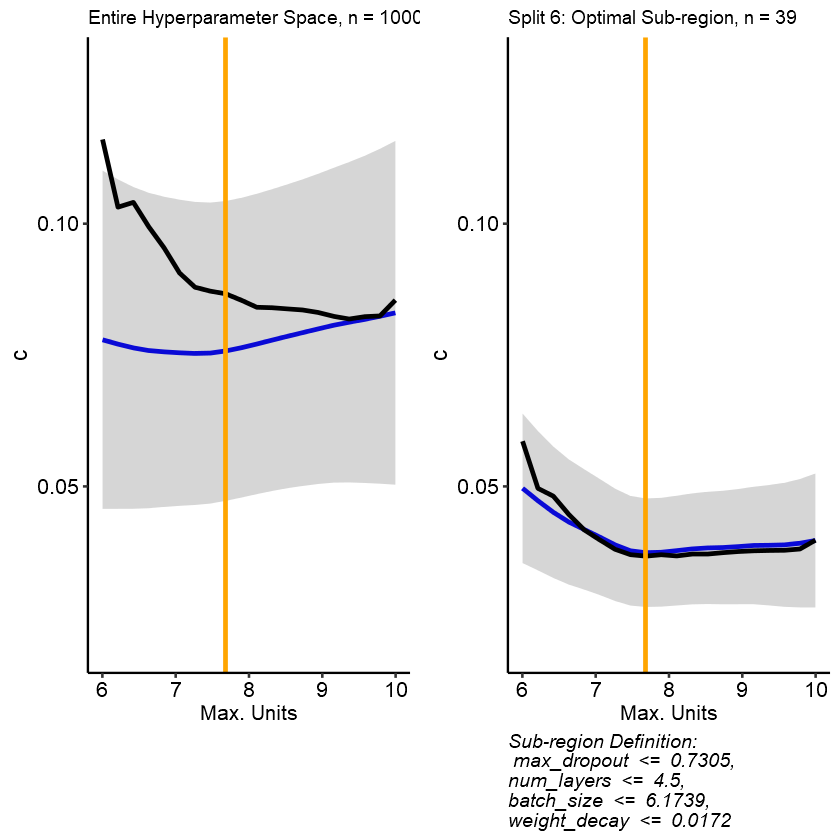

In [41]:
y_lim = c(0.02, 0.13)

# Global PDP with confidence bands
p.pdp = ggplot(data = data.pdp, aes_string(x = feat, y = "mean")) + 
  geom_line(colour = "blue", lwd = 1) + 
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.2) + 
  geom_line(data = gt.pdp, lwd = 1) +
  geom_vline(aes(xintercept = as.numeric(optimum[feat])), colour = "orange", lwd = 1) +
  ylim(y_lim) + xlab("Max. Units") + ylab("c") +
  labs(title = paste0("Entire Hyperparameter Space, n = ", 1000),
       caption = paste(paste(rep("\n",4), collapse = " "))) +
  theme(plot.caption = element_text(hjust = 0, face= "italic", size = 11),
        plot.title = element_text(size = 11),
        axis.title.y = element_text(size = 14))

# Sub-regional PDP with confidence bands
p.pdp.opt = ggplot(data = pdp.opt, aes_string(x = feat, y = "mean")) + 
  geom_line(colour = "blue", lwd = 1) + 
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.2) + 
  geom_line(data = gt.opt, lwd = 1) +
  geom_vline(aes(xintercept = as.numeric(optimum[feat])), colour = "orange", lwd = 1) +
  xlab("Max. Units") + ylim(y_lim) + ylab("c")  + 
  labs(title = paste0("Split 6: Optimal Sub-region, n = ", length(ind.opt)),
       caption = paste("Sub-region Definition: \n", 
                       paste(split.criteria$features[c(3:6)], ifelse(split.criteria$id[c(3:6)] == 1, " <= ", " > "),
                                                         split.criteria$values[c(3:6)], collapse = ", \n"))) +
  theme(plot.caption = element_text(hjust = 0, face= "italic", size = 11),
        plot.title = element_text(size = 11),
        axis.title.y = element_text(size = 14))


p1 = gridExtra::grid.arrange(p.pdp, p.pdp.opt, nrow = 1)

#### Prepare data for hyperparameter Batch Size

In [33]:
# Calculate PDP and confidence estimates for hyperparameter max_units and iteration 1
iter = 1
feat = "batch_size"

# calculate global PDP and confidence bands
data = data.all$result[[1]]$reslist[[iter]][[feat]]
data.pdp = data$res.pdp
data.pdp$lower = data.pdp$mean - data.pdp$sd*1.96
data.pdp$upper = data.pdp$mean + data.pdp$sd*1.96

# Extract ICE curves
data.ice = data$res.ice

# Extract tree and split criteria for optimal subregions
tree = data$trees
split.criteria = find_split_criteria(tree[[1]], optimum)
split.criteria$values = round(split.criteria$values, 4)

# Extract true PDP and ICE estimates
gt.feat = gt[[1]][[feat]][[1]]
gt.pdp = gt.feat[gt.feat$.type=="pdp",]
gt.ice = gt.feat[gt.feat$.type == "ice",]

# Calculate PDP and confidence estimates for optimal subregion after last split
optimal.node = find_optimal_node(tree[[1]], optimum)
ind.opt = optimal.node$subset.idx
pdp.opt = data.ice[data.ice$.id %in% ind.opt,] %>% group_by(get(feat)) %>% summarise(mean.opt = mean(mean), sd.opt = mean(sd))
pdp.opt$lower = pdp.opt$mean.opt - pdp.opt$sd.opt*1.96
pdp.opt$upper = pdp.opt$mean.opt + pdp.opt$sd.opt*1.96
colnames(pdp.opt) = c(feat, "mean", "sd",   "lower" , "upper")
gt.opt = gt.ice[gt.ice$.id %in% ind.opt,] %>% group_by(get(feat)) %>% summarise(mean.opt = mean(mean))
colnames(gt.opt) = c(feat, "mean")

#### Create plots for hyperparameter Batch Size

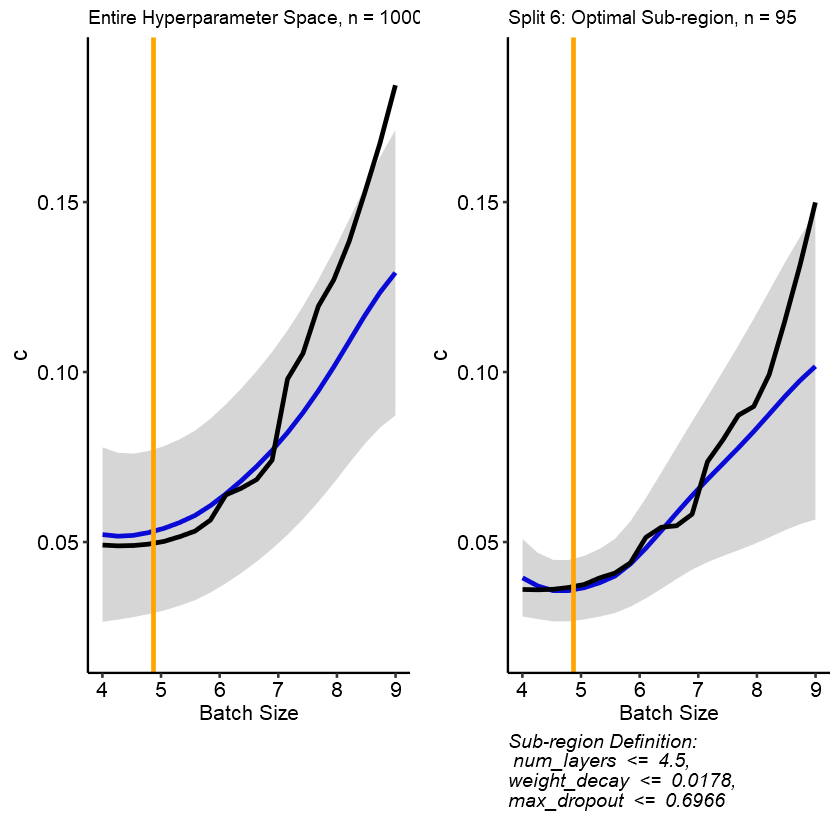

In [38]:
y_lim = c(0.02, 0.19)

# Global PDP with confidence bands
p.pdp = ggplot(data = data.pdp, aes_string(x = feat, y = "mean")) + 
  geom_line(colour = "blue", lwd = 1) + 
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.2) + 
  geom_line(data = gt.pdp, lwd = 1) +
  geom_vline(aes(xintercept = as.numeric(optimum[feat])), colour = "orange", lwd = 1) +
  ylim(y_lim) + xlab("Batch Size") + ylab("c") +
  labs(title = paste0("Entire Hyperparameter Space, n = ", 1000),
       caption = paste(paste(rep("\n",4), collapse = " "))) +
  theme(plot.caption = element_text(hjust = 0, face= "italic", size = 11),
        plot.title = element_text(size = 11),
        axis.title.y = element_text(size = 14))

# Sub-regional PDP with confidence bands
p.pdp.opt = ggplot(data = pdp.opt, aes_string(x = feat, y = "mean")) + 
  geom_line(colour = "blue", lwd = 1) + 
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.2) + 
  geom_line(data = gt.opt, lwd = 1) +
  geom_vline(aes(xintercept = as.numeric(optimum[feat])), colour = "orange", lwd = 1) +
  ylim(y_lim) + xlab("Batch Size") + ylab("c") + 
  labs(title = paste0("Split 6: Optimal Sub-region, n = ", length(ind.opt)),
       caption = paste("Sub-region Definition:\n", 
                       paste(split.criteria$features[c(4:6)], ifelse(split.criteria$id[c(4:6)] == 1, " <= ", " > "),
                       split.criteria$values[c(4:6)], collapse = ", \n"), "\n")) +
  theme(plot.caption = element_text(hjust = 0, face= "italic", size = 11),
        plot.title = element_text(size = 11),
        axis.title.y = element_text(size = 14))


p2 = gridExtra::grid.arrange(p.pdp, p.pdp.opt, nrow = 1)

#### Print Figure

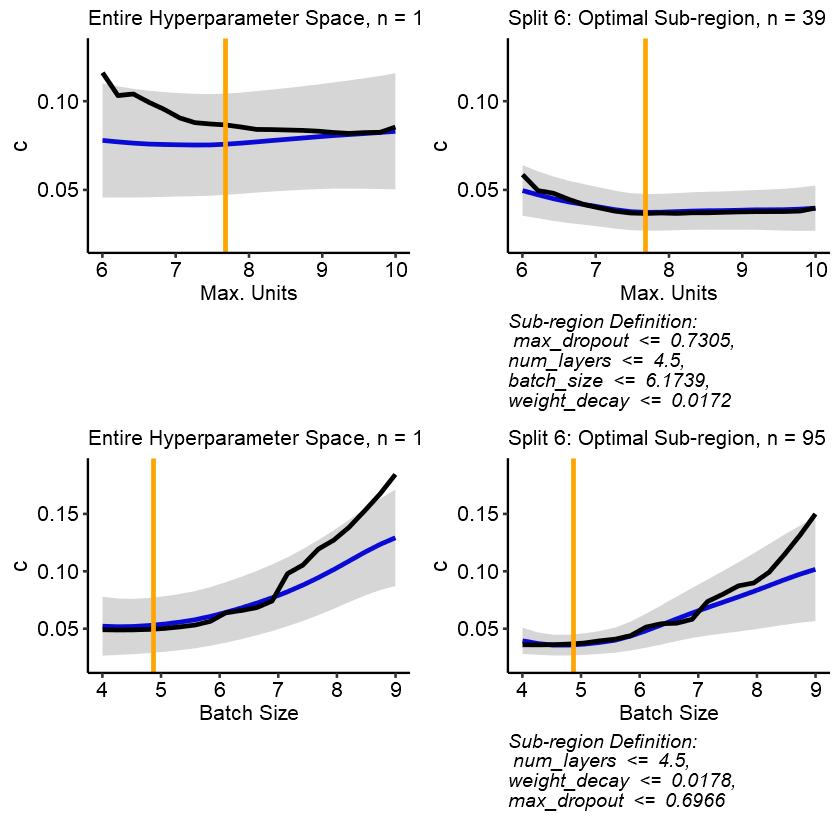

In [37]:
gridExtra::grid.arrange(p1,p2, nrow = 2)